# Benchmark Model
This model has been created as a benchmark to compare the performance of the other models. This model will merely predict the average of the values. For a direct comparison, this benchmark model will use the same image size and amount of images as the ones used in the custom model.

This notebook is structured as follows:
* [1. Data Wrangling](#1)
    * [1.1 Loading Keypoints Data](#1.2)
    * [1.2 Images Data](#1.2)
    * [1.3 Preprocessing](#1.3)
* [2. Helper Functions](#2)
* [3. Modeling](#3)
    * [2.1 Splitting Data](#3.1)
    * [2.2 Building Model](#3.2)
    * [2.3 Testing and Evaluating Model](#3.3)

In [1]:
#Ignore warnings for a cleaner display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import keras
import tensorflow as tf
import PIL

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing import image

# 1. Data Wrangling <a name='1'></a>

## 1.1 Loading Keypoints Data <a name='1.1'></a>
I will be using the same amount of dataset as used in the custom model for a direct comparison: 35,000 total images at 65x80.

In [3]:
#Define paths to keypoints datasets
keypts_data_path = "../input/celeba-dataset/list_landmarks_align_celeba.csv"
images_data_path = "../input/celeba-dataset/img_align_celeba/img_align_celeba"

#Select only 35k images first
img_data_size = 35000

#Original image dimensions
x_og = 178
y_og = 218

# New image dimensions
x_ = 80
image_size_ratio = x_og / y_og
y_ = int(image_size_ratio * x_)

# Image Sizes
original_image_size = (x_og, y_og)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size

In [4]:
keypts_og = pd.read_csv(keypts_data_path)[:img_data_size]
keypts_og.sample(5)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
19880,019881.jpg,69,110,107,112,98,134,70,152,108,153
12223,012224.jpg,67,112,110,112,86,135,65,151,112,150
32081,032082.jpg,70,111,107,111,85,135,73,152,104,153
14026,014027.jpg,71,109,105,111,92,129,76,154,103,154
13799,013800.jpg,68,112,109,112,85,141,70,151,107,151


In [5]:
keypts_og.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,69.368743,111.189143,107.625971,111.153229,88.030029,135.075829,71.282286,152.119200,105.553571,152.215571
std,1.717107,1.128984,1.685886,1.178651,6.702350,4.264796,3.171467,1.795088,3.241235,1.736808
min,60.000000,99.000000,90.000000,99.000000,59.000000,102.000000,60.000000,142.000000,90.000000,139.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,74.000000,153.000000,108.000000,153.000000
max,85.000000,121.000000,121.000000,120.000000,120.000000,154.000000,88.000000,168.000000,119.000000,170.000000


In [6]:
keypts_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      35000 non-null  object
 1   lefteye_x     35000 non-null  int64 
 2   lefteye_y     35000 non-null  int64 
 3   righteye_x    35000 non-null  int64 
 4   righteye_y    35000 non-null  int64 
 5   nose_x        35000 non-null  int64 
 6   nose_y        35000 non-null  int64 
 7   leftmouth_x   35000 non-null  int64 
 8   leftmouth_y   35000 non-null  int64 
 9   rightmouth_x  35000 non-null  int64 
 10  rightmouth_y  35000 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 2.9+ MB


In [7]:
keypts_og.shape

(35000, 11)

## 1.2 Images Data <a name='1.2'></a>
Loading the images data involves converting it to arrays so it may be used it in training the model. They're being resized.

In [8]:
images = []

for idx in range(keypts_og.shape[0]):
    #Retrieve path
    path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[idx].image_id))
    
    #Reading images
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    
    #Append images
    images.append(image_array)

In [9]:
#Convert to array
images = np.array(images)

images.shape

(35000, 65, 80, 3)

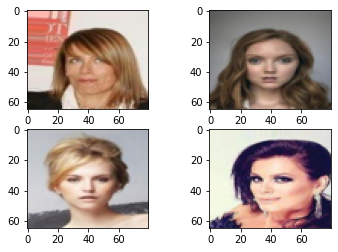

In [10]:
#Plotting sample images
idx1, idx2, idx3, idx4 = np.random.randint(0, img_data_size, size=4)

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(images[idx1])
axs[1,0].imshow(images[idx2])
axs[1,1].imshow(images[idx3])
axs[0,1].imshow(images[idx4])
plt.show()

## 1.3 Preprocessing <a name='1.3'></a>

Since the image sizes were scaled down, the key points need to also be appropriately rescaled.

In [11]:
#Copy the original dataframe to leave it intact
keypts = keypts_og.copy()

x_old, y_old = original_image_size
x_new, y_new = image_size_training

#Get ratio of new to old for rescaling
x_ratio = x_new / x_old
y_ratio = y_new / y_old

keypts_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
keypts_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']

#Rescale the keypoints
keypts[keypts_x] = (keypts[keypts_x] * x_ratio)
keypts[keypts_y] = (keypts[keypts_y] * y_ratio)

In [12]:
#Compare with original to make sure it's been rescaled
keypts_og.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [13]:
keypts.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,31.011236,32.500000,47.640449,33.692661,34.606742,42.339450,32.808989,45.321101,48.539326,45.917431
1,000002.jpg,31.011236,32.798165,48.089888,33.394495,36.404494,40.252294,31.460674,45.022936,48.539326,45.619266
2,000003.jpg,34.157303,33.394495,46.741573,31.605505,48.539326,38.165138,33.258427,46.513761,44.044944,47.110092
3,000004.jpg,32.359551,33.692661,48.539326,32.201835,45.393258,41.146789,31.910112,46.215596,45.393258,45.022936
4,000005.jpg,29.662921,33.990826,50.337079,33.394495,38.651685,35.481651,31.910112,43.830275,46.741573,44.724771


In [14]:
keypts.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,31.176963,33.152726,48.371223,33.142018,39.564058,40.274903,32.036982,45.356642,47.439807,45.385377
std,0.771733,0.336624,0.757702,0.351433,3.012292,1.271613,1.425378,0.535233,1.456735,0.517855
min,26.966292,29.518349,40.449438,29.518349,26.516854,30.412844,26.966292,42.339450,40.449438,41.444954
25%,30.561798,33.096330,48.089888,33.096330,37.752809,39.655963,31.011236,45.022936,46.292135,45.022936
50%,31.011236,33.096330,48.539326,33.096330,39.550562,40.252294,32.359551,45.321101,47.191011,45.321101
75%,31.460674,33.394495,48.988764,33.394495,41.348315,41.146789,33.258427,45.619266,48.539326,45.619266
max,38.202247,36.077982,54.382022,35.779817,53.932584,45.917431,39.550562,50.091743,53.483146,50.688073


# 2. Helper Functions <a name='2'></a>

In [15]:
#Read image based on index
def imread_index(index, size=image_size_training, path=images_data_path):
    """This function helps read images based on the its index by converting it to an array.
    """
    path = "{}/{}".format(str(path), str(keypts_og.iloc[index].image_id))
    
    #read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

In [16]:
#Get a list of all key points of the face
def img_keypts_list(index, df=keypts_og):
    """ This function returns a list of all the key points of the face image so 
    it's easier to plot
    """
    points_list = [df.iloc[index].lefteye_x, df.iloc[index].lefteye_y,
                  df.iloc[index].righteye_x, df.iloc[index].righteye_y,
                  df.iloc[index].nose_x, df.iloc[index].nose_y,
                  df.iloc[index].leftmouth_x, df.iloc[index].leftmouth_y,
                  df.iloc[index].rightmouth_x, df.iloc[index].rightmouth_y]
    
    return points_list

In [17]:
#Plot image with green bounding box and keypoints
def plot_face_bbox(index, df=keypts_og, size=original_image_size):
    """ This function plots the face image with its keypoints and bounding box
    """
    img = imread_index(index, size)
    points_list = img_keypts_list(index, df)
    
    #Plotting the image
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    #Plot the face points
    ax.plot(points_list[::2], points_list[1::2], 'bo-')
    
    #Plot bounding box
    width = abs(points_list[0] - points_list[8] - 60) #obtain width from left eye x to right mouth x
    height = abs(points_list[1] - points_list[9] - 75)#obtain width from left eye y to right mouth y
    rect = patches.Rectangle((points_list[0]-30, points_list[1]-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    
    #Remove axis
    plt.axis('off')
    plt.show()

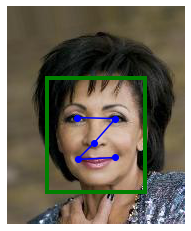

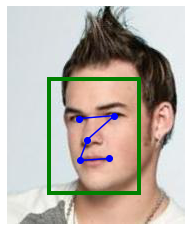

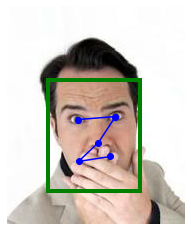

In [18]:
#test
idx1, idx2, idx3 = np.random.randint(0, img_data_size, size=3)

#Test plotting sample images
plot_face_bbox(idx1)
plot_face_bbox(idx2)
plot_face_bbox(idx3)

# 3. Modeling <a name='3'></a>

## 3.1 Splitting data into training and test datasets <a name='3.1'></a>

In [19]:
#Seaparate 20% for the test set
test_size = int(img_data_size * 0.2)

# training data
train_labels = keypts[:img_data_size - test_size]
train_images = images[:img_data_size - test_size]


# test data
test_labels = keypts[img_data_size - test_size + 1:]
test_images = images[img_data_size - test_size + 1:]

### Train and Validation Sets

In [20]:
#Dropping image_id column
y = train_labels.drop(['image_id'], axis = 1) 
X = train_images

# check
y.head(3)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,31.011236,32.500000,47.640449,33.692661,34.606742,42.339450,32.808989,45.321101,48.539326,45.917431
1,31.011236,32.798165,48.089888,33.394495,36.404494,40.252294,31.460674,45.022936,48.539326,45.619266
2,34.157303,33.394495,46.741573,31.605505,48.539326,38.165138,33.258427,46.513761,44.044944,47.110092


In [21]:
#Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state = 42)

#Check the ratio
X_val.shape[0]/X_train.shape[0]

0.25

## 3.2 Building the Model <a name='3.2'></a>
This model will simply predict the averages of the training set values every time.

In [22]:
#Obtain the averages of the training set
avgs = train_labels.drop(['image_id'],axis=1).mean()
avgs

lefteye_x       31.174222
lefteye_y       33.153141
righteye_x      48.373419
righteye_y      33.142684
nose_x          39.568058
nose_y          40.273453
leftmouth_x     32.035457
leftmouth_y     45.354602
rightmouth_x    47.442825
rightmouth_y    45.386356
dtype: float64

## 3.3 Testing and Evaluating the Model <a name='3.3'></a>

In [23]:
# function to plot the image with green box around the faces
def plot_test_img(index, pred_or_actual = 'pred', pointsColor='ro-', boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_og,x_og,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    
    #Obtain predictions for key points of face
    if pred_or_actual == 'pred':
        img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255
      
        points_list = avgs.astype('int')
        
        #convert key pts values to original size
        x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
        y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
        
        points_list[0] = int(points_list[0] * x_ratio)
        points_list[2] = int(points_list[2] * x_ratio)
        points_list[4] = int(points_list[4] * x_ratio)
        points_list[6] = int(points_list[6] * x_ratio)
        points_list[8] = int(points_list[8] * x_ratio)
    
        points_list[1] = int(points_list[1] * y_ratio)
        points_list[3] = int(points_list[3] * y_ratio)
        points_list[5] = int(points_list[5] * y_ratio)
        points_list[7] = int(points_list[7] * y_ratio)
        points_list[9] = int(points_list[9] * y_ratio)
        
        title = 'Predicted'
        
    elif pred_or_actual == 'actual':      
        points_list = img_keypts_list(index)
        pointsColor = 'bo-'
        title = 'Actual'
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)
    ax.set_title(title)
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

[70, 111, 107, 111, 84, 133, 74, 153, 103, 153]

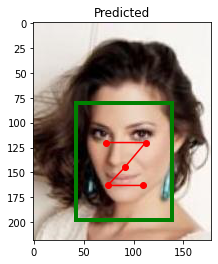

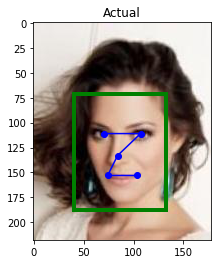

In [24]:
index = 14405
plot_test_img(index, pred_or_actual = 'pred')
plot_test_img(index, pred_or_actual='actual')

I'd also like to evaluate the model MSE per each coordinate.

In [25]:
#Evaluation function to calculate MSE for each coordinate
def eval_model(labels, predictions, as_df=False):
    """Calculate the MSE for each for ten coordinates, plus an average of all the MSEs, with the option to output as a DataFrame or a list."""
    mse_list = []
    
    #Calculate each MSE and add to list
    for i in np.arange(10):
        if (type(labels)==pd.DataFrame):
            mse_list.append(mean_squared_error(labels.iloc[:,i], np.full(len(labels), predictions[i])))
        else:
            mse_list.append(mean_squared_error([label[i] for label in labels], predictions[i]))
    
    #Calculate average MSE
    mse_list.append(np.mean(mse_list))
    
    #Optional output as dataframe
    if (as_df):
        cols = keypts_og.columns[1:].tolist()
        cols.append('average')
        
        df = pd.DataFrame(columns=cols)
        df.loc['MSE'] = mse_list
        
        return df
    #Otherwise output as list
    else: return mse_list

In [26]:
test_lbs = test_labels.drop(['image_id'], axis=1)

evaluate = eval_model(test_lbs, avgs, as_df=True)
evaluate

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,average
MSE,0.607453,0.116987,0.59638,0.120998,9.215325,1.57629,2.045889,0.295481,2.09424,0.273133,1.694218


## Saving the Model

This information will be saved in a more accessible .csv file for comparison between models. 

Since there is no real training done on this model, I will skip those columns. For a scale-invariant metric, percentage error will also be collected: the MSE values will be converted to RMSE and standardized, by dividing by the average value and multiplied by 100.


In [27]:
#Load the model csv
model_data_path = '../input/model-data/model_data.csv'
exp = pd.read_csv(model_data_path, index_col=0)
exp

,loss,val_loss,epoch,batch,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,...,scaled_lefteye_x,scaled_lefteye_y,scaled_righteye_x,scaled_righteye_y,scaled_nose_x,scaled_nose_y,scaled_leftmouth_x,scaled_leftmouth_y,scaled_rightmouth_x,scaled_rightmouth_y
Custom,"[488.2683410644531, 178.78807067871094, 128.86...","[432.4057922363281, 359.76934814453125, 364.08...",300,200,0.550627,0.129648,0.659737,0.121735,2.054469,1.611473,...,2.3801,1.086083,1.679185,1.052759,3.622839,3.151933,4.333488,1.542611,2.933389,1.498164


In [28]:
exp

,loss,val_loss,epoch,batch,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,...,scaled_lefteye_x,scaled_lefteye_y,scaled_righteye_x,scaled_righteye_y,scaled_nose_x,scaled_nose_y,scaled_leftmouth_x,scaled_leftmouth_y,scaled_rightmouth_x,scaled_rightmouth_y
Custom,"[488.2683410644531, 178.78807067871094, 128.86...","[432.4057922363281, 359.76934814453125, 364.08...",300,200,0.550627,0.129648,0.659737,0.121735,2.054469,1.611473,...,2.3801,1.086083,1.679185,1.052759,3.622839,3.151933,4.333488,1.542611,2.933389,1.498164


In [29]:
#Add benchmark metrics
exp = pd.concat([exp, evaluate.rename(index={'MSE':'Benchmark'})])

cols = evaluate.columns[:-1].tolist()

#Add scaled benchmark eval metrics
for col in cols:
    new_column = 'scaled_' + col
    
    #Convert to RMSE then divide by the coordinate average
    exp.loc['Benchmark', new_column] = np.sqrt(exp.loc['Benchmark', col]) / keypts[col].mean() * 100

#Add scaled average metric
avg = np.mean(exp.iloc[1, -10:])
exp.loc['Benchmark', 'scaled_avg'] = avg

exp

,loss,val_loss,epoch,batch,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,...,scaled_lefteye_y,scaled_righteye_x,scaled_righteye_y,scaled_nose_x,scaled_nose_y,scaled_leftmouth_x,scaled_leftmouth_y,scaled_rightmouth_x,scaled_rightmouth_y,scaled_avg
Custom,"[488.2683410644531, 178.78807067871094, 128.86...","[432.4057922363281, 359.76934814453125, 364.08...",300.0,200.0,0.550627,0.129648,0.659737,0.121735,2.054469,1.611473,...,1.086083,1.679185,1.052759,3.622839,3.151933,4.333488,1.542611,2.933389,1.498164,NaN
Benchmark,NaN,NaN,NaN,NaN,0.607453,0.116987,0.596380,0.120998,9.215325,1.576290,...,1.031692,1.596521,1.049569,7.672811,3.117335,4.464671,1.198461,3.050495,1.151519,2.683297


In [30]:
exp.loc['Benchmark']

loss                        NaN
val_loss                    NaN
epoch                       NaN
batch                       NaN
lefteye_x              0.607453
lefteye_y              0.116987
righteye_x              0.59638
righteye_y             0.120998
nose_x                 9.215325
nose_y                  1.57629
leftmouth_x            2.045889
leftmouth_y            0.295481
rightmouth_x            2.09424
rightmouth_y           0.273133
average                1.694218
scaled_lefteye_x         2.4999
scaled_lefteye_y       1.031692
scaled_righteye_x      1.596521
scaled_righteye_y      1.049569
scaled_nose_x          7.672811
scaled_nose_y          3.117335
scaled_leftmouth_x     4.464671
scaled_leftmouth_y     1.198461
scaled_rightmouth_x    3.050495
scaled_rightmouth_y    1.151519
scaled_avg             2.683297
Name: Benchmark, dtype: object

In [31]:
#Save dataframe as .csv
exp.to_csv('model_data.csv')

In [32]:
#Download csv
from IPython.display import FileLink
FileLink(r'model_data.csv')

/kaggle/working/model_data.csv